In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
# ==============================
# Amazon Clothing EDA Project
# ==============================


In [47]:
sheet_id = "1XU8dWfq_MbKqgRsXFcUNZCtpnk2fWmNlMX-Hq1IO4mc" # Your Google Sheet ID
gid = "1183921394"  # This identifies the specific sheet/tab inside the spreadsheet or Your Google Sheet Tab GID

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
df = pd.read_csv(url)

print("Shape of DataFrame:", df.shape)
display(df.head()) 

Shape of DataFrame: (25000, 19)


,order_id,customer_id,product_id,product_name,main_category,sub_category,brand,price,quantity,discount_percent,final_price,payment_method,review_rating,order_date,delivery_days,is_returned,region,customer_age_group,device_type
0,#HLWTRIGAJB0RFL,A86556872001,6Q3V14RXRF,Huggies Rompers,baby,Rompers,Huggies,118.62,1,10,106.76,PayPal,3,2024-09-10,5.0,0,Midwest,25-34,Mobile
1,#9LMWG6T6H0IPE0,0A9218115AAA,33MRMEM3WN,Gerber Blankets,Baby,Blankets,Gerber,26.84,1,15,22.81,Gift Card,2,2025-06-25,8.0,0,West,25-34,Mobile
2,#Q6J5C5621SSE5V,8A5A09200074,E674NZH16V,Fossil Jeans,Men,Jeans,Fossil,219.38,2,25,329.07,Gift Card,4,2025-01-08,5.0,0,Northeast,35-44,Mobile
3,#J145DOUKB5RVBN,97602786977A,ETMIXJHFAT,Carter's Rompers,Baby,Rompers,Carter's,12.05,1,0,12.05,Credit Card,5,2024-08-28,3.0,0,Midwest,45-54,Mobile
4,#7ZXNMSUU22AK4J,744297746010,5BYOWYYY5P,Adidas Sneakers,Kids,Sneakers,Adidas,145.36,1,10,130.82,Credit Card,1,2024-11-12,5.0,0,NaN,45-54,Mobile


In [48]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
order_id                 0
customer_id              0
product_id               0
product_name             0
main_category            0
sub_category             0
brand                 1250
price                  250
quantity                 0
discount_percent         0
final_price              0
payment_method        1250
review_rating            0
order_date               0
delivery_days          250
is_returned              0
region                1250
customer_age_group    1250
device_type           1250
dtype: int64


In [50]:
# Handle duplicates
df = df.drop_duplicates()

In [51]:
# Validate consistency of price, discount_percent, final_price
df["calc_final_price"] = df["price"] * (1 - df["discount_percent"]/100)

In [52]:
# Feature Engineering
df["order_date"] = pd.to_datetime(df["order_date"])
df["order_month"] = df["order_date"].dt.month
df["order_year"] = df["order_date"].dt.year
df["order_weekday"] = df["order_date"].dt.day_name()
df["discount_amount"] = df["price"] * df["discount_percent"] / 100
df["unit_price"] = df["final_price"] / df["quantity"]
df["delivery_flag"] = np.where(df["delivery_days"] <= 3, "fast", "slow")

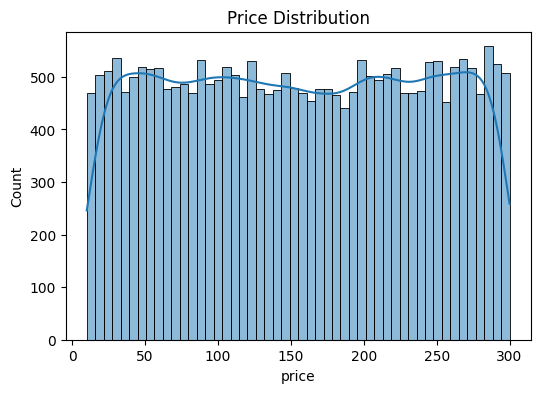

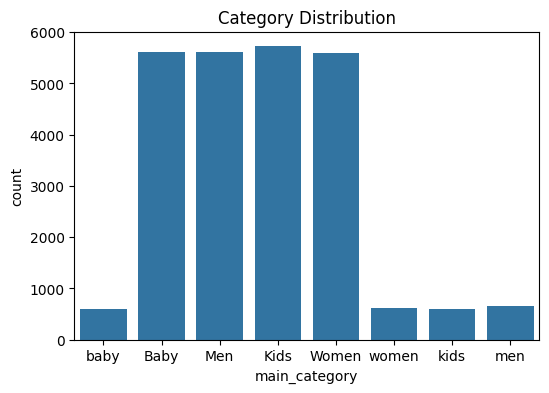

Return rate: 9.84%


In [53]:
# ------------------------------
# B. Univariate Analysis
# ------------------------------


plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()


plt.figure(figsize=(6,4))
sns.countplot(x="main_category", data=df)
plt.title("Category Distribution")
plt.show()


return_rate = df["is_returned"].mean()
print(f"Return rate: {return_rate:.2%}")

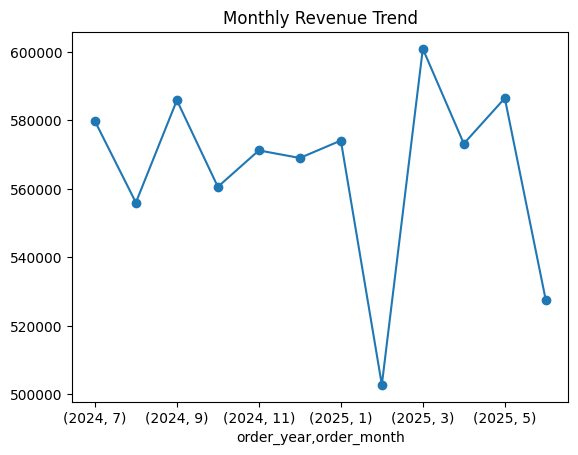

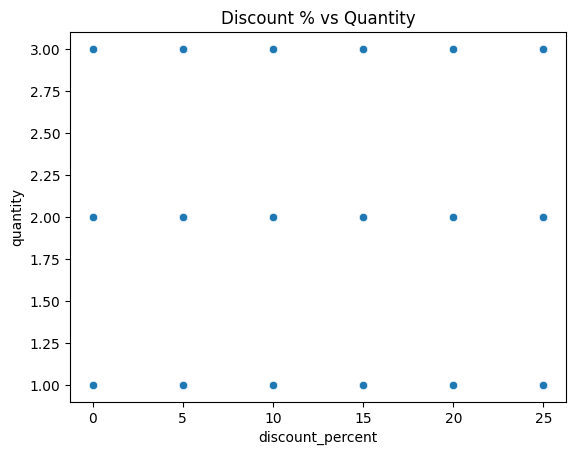

main_category
Baby     0.097966
Kids     0.096053
Men      0.100588
Women    0.097587
baby     0.098472
kids     0.084746
men      0.130168
women    0.092652
Name: is_returned, dtype: float64


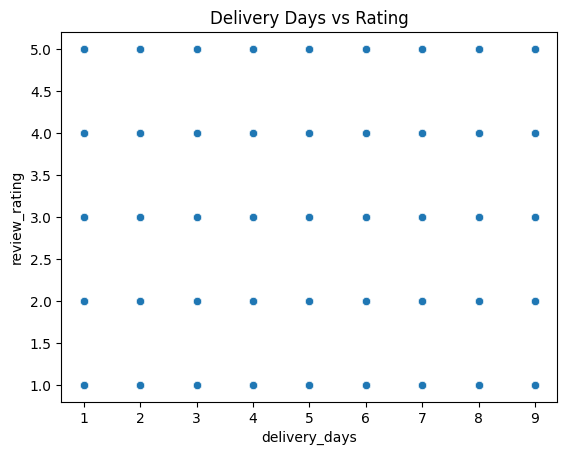

In [54]:
# ------------------------------
# C. Bivariate & Multivariate Analysis
# ------------------------------


revenue_trend = df.groupby(["order_year","order_month"])['final_price'].sum()
revenue_trend.plot(kind='line', marker='o', title="Monthly Revenue Trend")
plt.show()


sns.scatterplot(x="discount_percent", y="quantity", data=df)
plt.title("Discount % vs Quantity")
plt.show()


return_by_cat = df.groupby("main_category")["is_returned"].mean()
print(return_by_cat)


sns.scatterplot(x="delivery_days", y="review_rating", data=df)
plt.title("Delivery Days vs Rating")
plt.show()

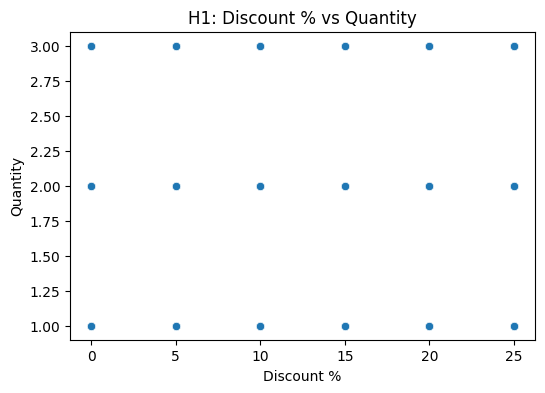

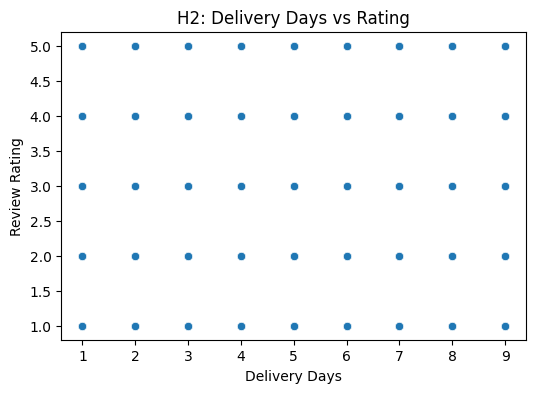

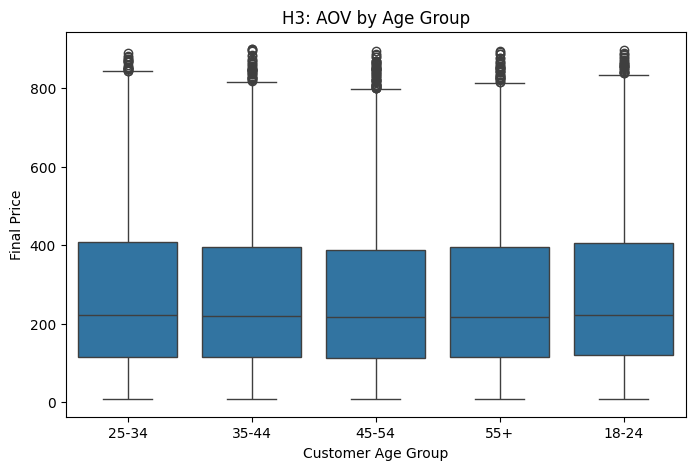

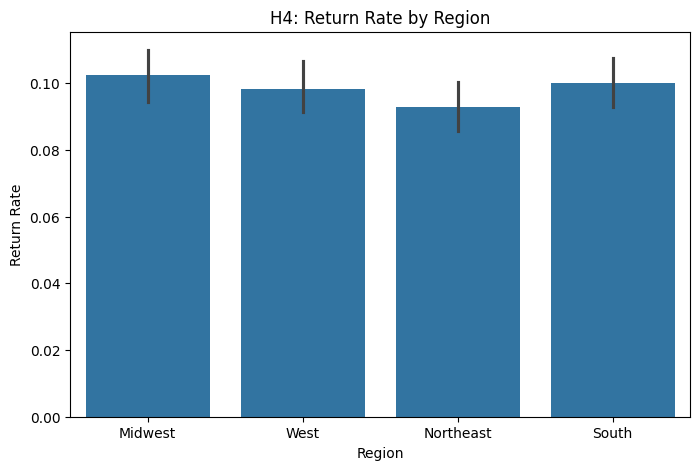

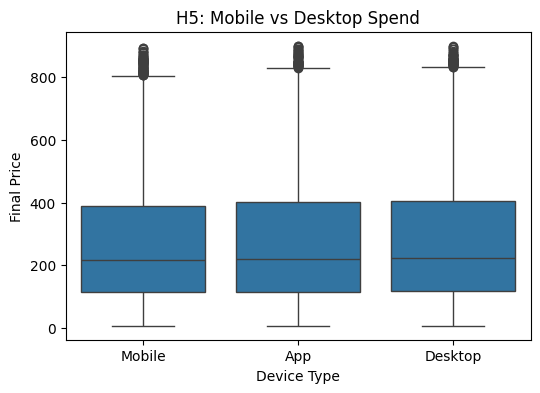

In [55]:
# ------------------------------
# D. Hypothesis Testing (Examples)
# ------------------------------


results_summary = {}


# H1: Higher discounts → Higher quantity sold
corr, pval = stats.pearsonr(df["discount_percent"], df["quantity"])
results_summary["H1"] = (corr, pval)


plt.figure(figsize=(6,4))
sns.scatterplot(x="discount_percent", y="quantity", data=df)
plt.title("H1: Discount % vs Quantity")
plt.xlabel("Discount %")
plt.ylabel("Quantity")
plt.show()


# H2: Longer delivery times → Lower ratings
corr2, pval2 = stats.pearsonr(df["delivery_days"], df["review_rating"])
results_summary["H2"] = (corr2, pval2)


plt.figure(figsize=(6,4))
sns.scatterplot(x="delivery_days", y="review_rating", data=df)
plt.title("H2: Delivery Days vs Rating")
plt.xlabel("Delivery Days")
plt.ylabel("Review Rating")
plt.show()


# H3: Age group differences in Average Order Value (AOV)
age_groups = df.groupby("customer_age_group")["final_price"].mean()


aov_data = [group["final_price"].values for _, group in df.groupby("customer_age_group")]
f_stat, p_val = stats.f_oneway(*aov_data)
results_summary["H3"] = (f_stat, p_val)


plt.figure(figsize=(8,5))
sns.boxplot(x="customer_age_group", y="final_price", data=df)
plt.title("H3: AOV by Age Group")
plt.xlabel("Customer Age Group")
plt.ylabel("Final Price")
plt.show()


# H4: Region differences in return behavior
returns_by_region = df.groupby("region")["is_returned"].mean()


contingency = pd.crosstab(df["region"], df["is_returned"])
chi2, p, dof, exp = stats.chi2_contingency(contingency)
results_summary["H4"] = (chi2, p)


plt.figure(figsize=(8,5))
sns.barplot(x="region", y="is_returned", data=df, estimator=np.mean)
plt.title("H4: Return Rate by Region")
plt.xlabel("Region")
plt.ylabel("Return Rate")
plt.show()


# H5: Mobile vs Desktop differences in spend
mobile_spend = df.loc[df["device_type"]=="Mobile", "final_price"]
desktop_spend = df.loc[df["device_type"]=="Desktop", "final_price"]
t_stat, p_val = stats.ttest_ind(mobile_spend, desktop_spend, equal_var=False)
results_summary["H5"] = (t_stat, p_val)


plt.figure(figsize=(6,4))
sns.boxplot(x="device_type", y="final_price", data=df)
plt.title("H5: Mobile vs Desktop Spend")
plt.xlabel("Device Type")
plt.ylabel("Final Price")
plt.show()

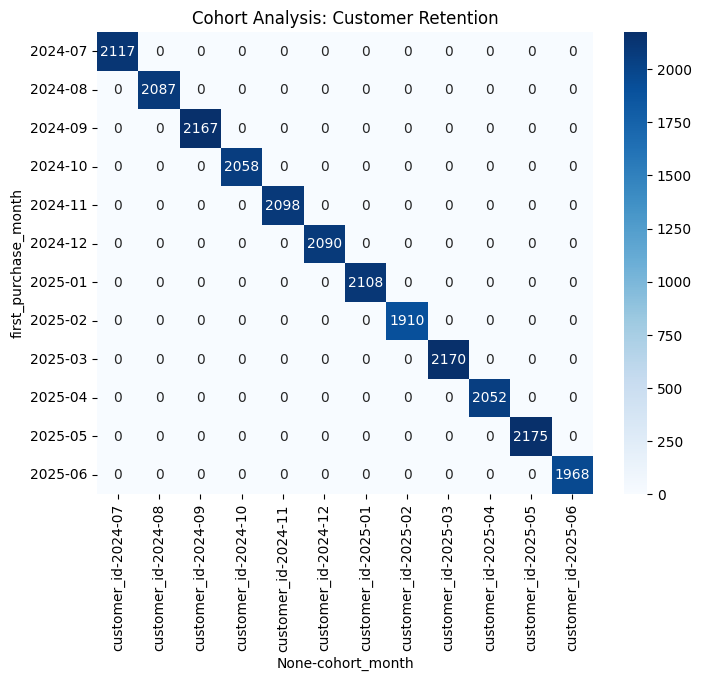

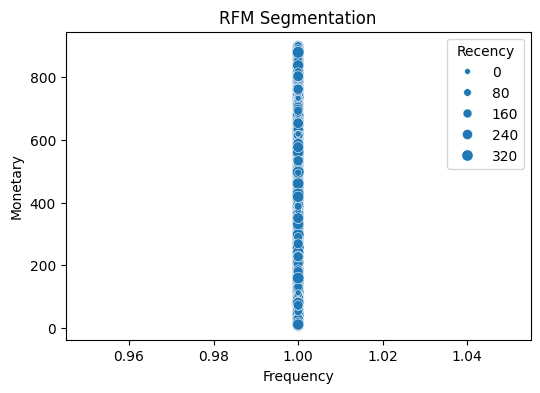

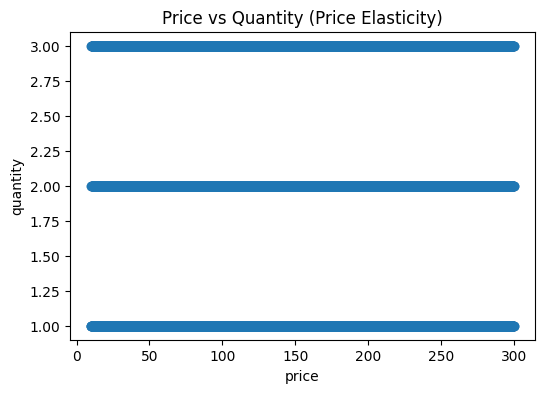

In [58]:
# ------------------------------
# E. Advanced Analyses (Optional)
# ------------------------------


# 1. Cohort Analysis (Customer Retention)
df["first_purchase_month"] = df.groupby("customer_id")["order_date"].transform("min").dt.to_period("M")
df["cohort_month"] = df["order_date"].dt.to_period("M")
cohort_data = df.groupby(["first_purchase_month", "cohort_month"]).agg({"customer_id": pd.Series.nunique})
cohort_data = cohort_data.unstack(fill_value=0)


plt.figure(figsize=(8,6))
sns.heatmap(cohort_data, annot=True, fmt="d", cmap="Blues")
plt.title("Cohort Analysis: Customer Retention")
plt.show()

# 2. RFM Segmentation (Recency, Frequency, Monetary)
rfm = df.groupby("customer_id").agg({
"order_date": lambda x: (df["order_date"].max() - x.max()).days,
"order_id": "count",
"final_price": "sum"
})
rfm.rename(columns={"order_date": "Recency", "order_id": "Frequency", "final_price": "Monetary"}, inplace=True)


plt.figure(figsize=(6,4))
sns.scatterplot(x="Frequency", y="Monetary", size="Recency", data=rfm)
plt.title("RFM Segmentation")
plt.show()

# 3. Price Elasticity (approximate)
plt.figure(figsize=(6,4))
sns.regplot(x="price", y="quantity", data=df, scatter_kws={"alpha":0.3})
plt.title("Price vs Quantity (Price Elasticity)")
plt.show()

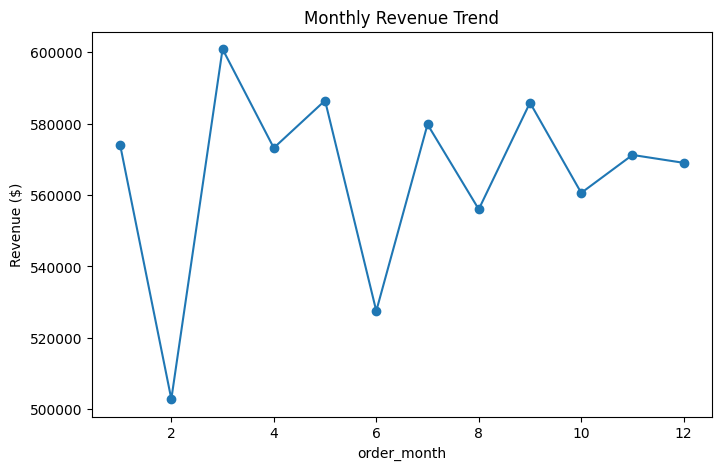

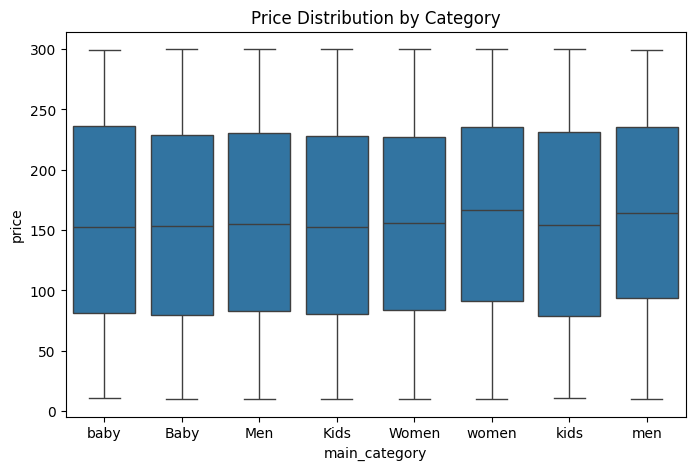

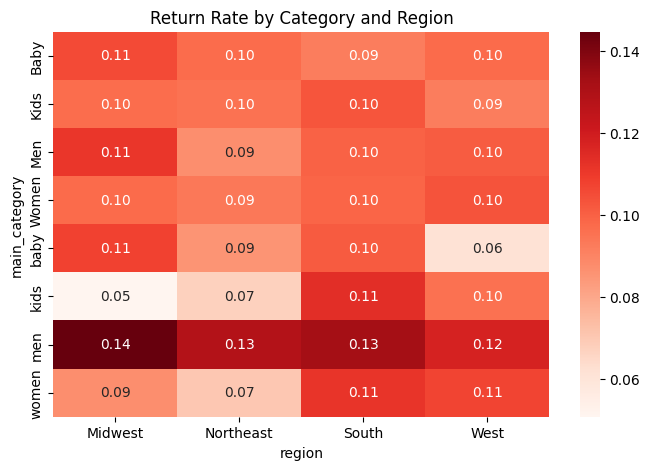

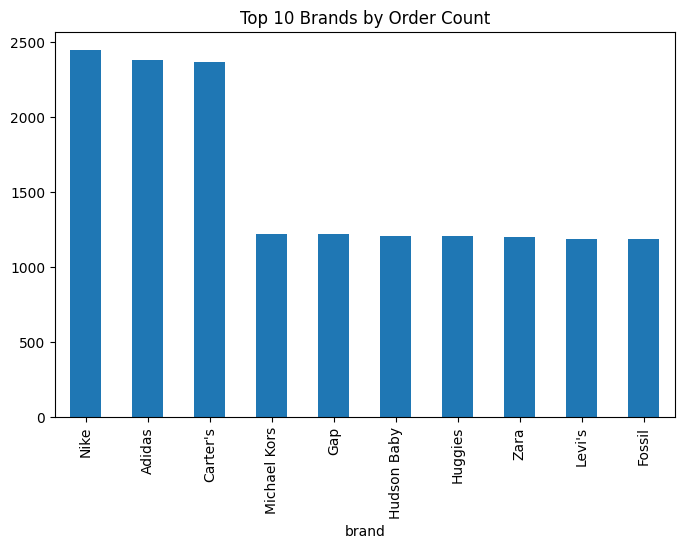

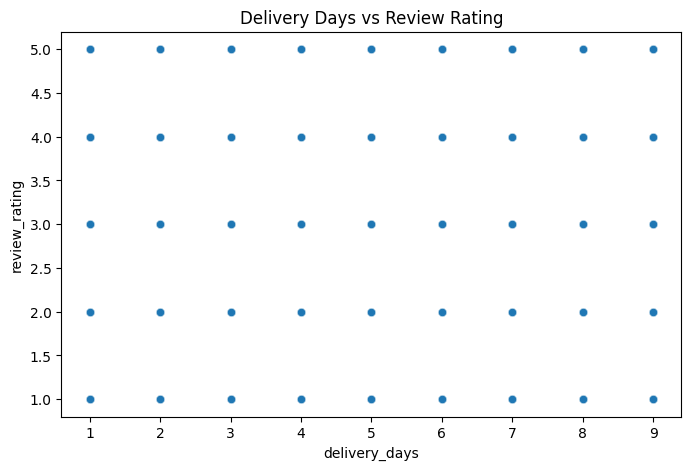

In [60]:
# ------------------------------
# F. Visualization Expectations
# ------------------------------


# Time Series: Revenue trend
plt.figure(figsize=(8,5))
df.groupby("order_month")["final_price"].sum().plot(marker='o')
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue ($)")
plt.show()


# Boxplot: Price distribution by category
plt.figure(figsize=(8,5))
sns.boxplot(x="main_category", y="price", data=df)
plt.title("Price Distribution by Category")
plt.show()


# Heatmap: Return rate by category × region
pivot = pd.pivot_table(df, values="is_returned", index="main_category", columns="region", aggfunc="mean")
plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds")
plt.title("Return Rate by Category and Region")
plt.show()


# Bar Chart: Top brands
plt.figure(figsize=(8,5))
df["brand"].value_counts().nlargest(10).plot(kind='bar')
plt.title("Top 10 Brands by Order Count")
plt.show()


# Scatter Plot: Delivery days vs Rating
plt.figure(figsize=(8,5))
sns.scatterplot(x="delivery_days", y="review_rating", data=df, alpha=0.5)
plt.title("Delivery Days vs Review Rating")
plt.show()

In [61]:
# ------------------------------
# G. Export Cleaned Data & Reports
# ------------------------------

df.to_csv("amazon_clothing_sales_cleaned.csv", index=False)

In [63]:

# ------------------------------
# H. Hypothesis Testing Summary
# ------------------------------
print("\n==== Hypothesis Testing Summary ====")
for h, (stat_val, p_val) in results_summary.items():
    conclusion = "Supported" if p_val < 0.05 else "Not Supported"
    print(f"{h}: Test statistic = {stat_val:.3f}, p-value = {p_val:.3f} → {conclusion}")



==== Hypothesis Testing Summary ====
H1: Test statistic = -0.000, p-value = 0.966 → Not Supported
H2: Test statistic = nan, p-value = nan → Not Supported
H3: Test statistic = 2.439, p-value = 0.045 → Supported
H4: Test statistic = 3.370, p-value = 0.338 → Not Supported
H5: Test statistic = -2.476, p-value = 0.013 → Supported
